In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [5]:
# 1. 生成假数据
# 假设我们有 1000 个样本，每个样本有 10 个特征，输出是 1 类（回归任务）
X = torch.randn(128,3,64,64)  # (3*64*64) batch_size = 128
y = torch.randn(128, 1)   # 输出标签（假设是回归任务）

# 构造 DataLoader
dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

#### ResBlock

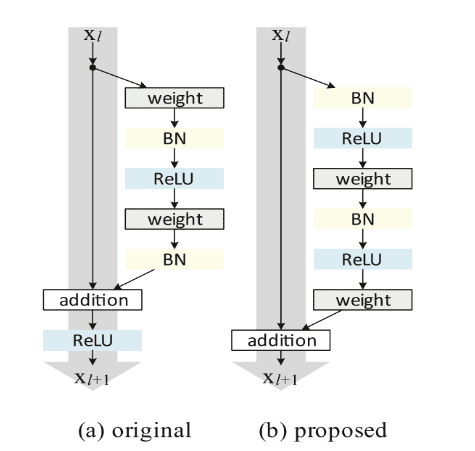

In [ ]:
class ResBlockOrign(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResBlockOrign, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        # 这里应该使用 out_channels 作为输入通道数
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU()

        self.resMeta = nn.Sequential(
            self.conv1,
            self.bn1,
            self.relu,
            self.conv2,
            self.bn2,
        )
    def forward(self, x):
        return self.relu(self.resMeta(x)+x)

#### ResNet Custom

In [ ]:
class ResNetCustom(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNetCustom, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        # 确保 layer1 和 layer2 的输入和输出通道数正确
        self.layer1 = self._make_layer(64, 64, 2)  # 不下采样层
        self.layer2 = self._make_layer(64, 128, 2, stride=2)  # 下采样层

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # 自适应平均池化
        self.fc = nn.Linear(128, num_classes)

    def _make_layer(self, in_channels, out_channels, blocks, stride=1):
        layers = []
        layers.append(ResBlockOrign(in_channels, out_channels, stride))
        for _ in range(1, blocks):
            layers.append(ResBlockOrign(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [8]:
# 3. 定义损失函数和优化器
model = ResNetCustom()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
# 4. 训练循环
for epoch in range(10):  # 进行 10 轮训练
    for inputs, targets in dataloader:
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')

RuntimeError: Given groups=1, weight of size [128, 64, 3, 3], expected input[32, 128, 32, 32] to have 64 channels, but got 128 channels instead